In [1]:
import cvxopt
from cvxopt import matrix, solvers
from sim3 import vt, dc, ap, qd, RLC, DCS, dcspeed
import numpy as np
import math
import control
import scipy.linalg as linalg
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from matplotlib import markers
from control.matlab import lsim

In [2]:
def get_control_limit(system):
    x_ref = system.ref_initial_in_right_shape 
    dis_A = np.array(system.sysd.A)
    dis_B = np.array(system.sysd.B)
    A_dimension = len(dis_A)

    control_limit = -1 * system.dis_B_inv @ (dis_A - np.eye(A_dimension)) @ x_ref
    return control_limit[0,0]

def attacked_state(system, type = 'surge'):
    if type == 'surge':
        system.place -= 1
    elif type == 'bias':
        system.thres = 100
    elif type == 'geo':
        previous = 400
        alpha = 0.8
        beta = 0.95
        coef = 2.5

    for i in range(0, system.slot+1):
        system.y_real_arr.append(system.xreal)
        system.score.append(system.s)
        distance = system.xmeasure-system.ref[i]
        system.cin = (-0.27698396)*(distance)+get_control_limit(system)
        if system.cin > system.limit_upbound:
            system.cin = system.limit_upbound
        elif system.cin < -1:
            system.cin = -1
        
        if type == 'surge':
            if i > system.place:
                if (i-400)%5 == 0:
                    system.att = system.thres + system.drift
                else:
                    system.att = system.drift
        elif type == 'bias':
            if i > system.place:
                system.att = system.thres/100+system.drift
        elif type == 'geo':
            if i > system.place:
                if (i-400)%5==0:
                    previous = i
                system.att = coef*beta*(alpha**(previous+6-i))
        
        yout, T, xout = lsim(system.sysc, system.cin, [0, system.Ts], system.xmeasure)
        yout2, T, xout2 = lsim(system.sysc, system.cin, [0, system.Ts], system.xreal)
        system.xreal = xout2[-1]
        xpred = xout[-1]
        system.xmeasure = xout[-1][0]-system.att
        if i > system.place:
            system.s = system.score[-1]+abs(xpred-system.xmeasure)-system.drift
    return system.y_real_arr

In [3]:
def short_mem_opt_attack(system, short_window = 25, which_optimal_row = 20, verbose = False):
    # General info of the system
    start_state = [1] # doesn't matter here
    x_ref = system.ref_initial_in_right_shape 
    
    cusum_thres = np.array([[system.thres]])  # self-defined
    cusum_drift = np.array([[system.drift]])  # can use drift = 0 for now
    
    dis_A = np.array(system.sysd.A)
    dis_B = np.array(system.sysd.B)
    con_A = np.array(system.A)
    con_B = np.array(system.B)
    A_dimension = len(dis_A)
    mins = []
    sols = []

    # control_limit: control signal that guarantees state to reach ref, u_0 term in notes
    # x_{i+1} = A @ x_i + B @ u_i, then u_i = control_limit => x_i = x_{i+1} = x_ref
    # -B^{-1} @ (A-I) @ x_ref = control_limit
    control_limit = -1 * system.dis_B_inv @ (dis_A - np.eye(A_dimension)) @ x_ref # 1.667
    if verbose: print(f'discretized matrics:\n A:- {dis_A}\n B:- {dis_B}\n B^-1:- {system.dis_B_inv}')
    if verbose: print(f'control limit is {control_limit}')
    limit_array = np.array([[control_limit[0,0]]])
    
    # Begin formulate LP problem, treat 100 as infinity in time
    steps = 100
        
    Big_A = -np.eye(A_dimension * steps) # coeffs of vars (states under opt attack at each step)
    Big_B = []  # constant upper bounds of vars
    Obj = [0] * steps
    Q = np.eye(A_dimension)
    R = [[1]]
        
    # Solve CARE for optimal control K backward from infinity horizon
    P = np.matrix(linalg.solve_continuous_are(con_A, con_B, Q, R))
    K = np.matrix(linalg.inv(R) * (con_B.T * P))
        
    # First rows of Big_A: cusum_i <= cusum_threshold for all step i
    if verbose: print("Preparing cusum constraints of A ...")
    mask = np.tril(np.ones((steps,steps)), -1)
    sub_A = dis_A - dis_B @ K - np.eye(A_dimension) 
    lower_A = np.kron(mask, sub_A)
    Big_A = np.array(Big_A + lower_A)
    # New: for short_window
    for i in range(steps-short_window):
        j = i+short_window
        Big_A[j:,i]+=1
        Big_A[j+1:,i]-=sub_A[0][0,0]+1
        
    # Next rows of Big_A: control constraints
    if verbose: print("Preparing control constraints of A ...")
    control_limit_array = np.zeros((steps,steps))
    for i in range(1, steps):
        control_limit_array[i, i-1] = -(K)[0][0,0]
    Big_A = np.concatenate((Big_A, control_limit_array))
        
    # Final rows of Big_A: absolute value constraint on |est_state - measured_state|
    if verbose: print("Preparing abs value constraints of A ...")
    attack_limit = np.eye(steps)
    for i in range(1, steps):
        attack_limit[i,i-1] = -(sub_A[0][0,0]+1)
    Big_A = np.concatenate((Big_A,attack_limit))
    
    # New: For short mem attack, modify Big_B with short_window
    # First rows of Big_B: cusum threshold
    if verbose: print("Preparing cusum constraints of B ...")
    cusum_thres_term = cusum_thres - (dis_A - dis_B @ K) @ start_state
    cusum_drift_term = cusum_drift - dis_B @ K @ x_ref - dis_B * control_limit
    for i in range(steps):
        if i < short_window:
            this_B =  cusum_drift_term * (i+1) + cusum_thres_term
        else:
            this_B = cusum_drift_term * (short_window) + cusum_thres
        for j in range(A_dimension):
            Big_B.append(this_B[j][0,0])
        
    # Next rows of Big_B: control constraints
    if verbose: print("Preparing control constraints of B ...")
    limit_upbound_term = (system.limit_upbound - K @ x_ref - limit_array)[0][0,0]
    for i in range(steps):
        Big_B.append(limit_upbound_term)
            
    # Final rows of Big_B: absolute value constraint on |est_state - measured_state|
    if verbose: print("Preparing abs value constraints of B ...")
    this_B_term = dis_B @ K @ x_ref + dis_B * control_limit 
    for i in range(steps):
        absolute_value_term = this_B_term[j][0, 0] ############################# is j supposed to be here?
        Big_B.append(absolute_value_term)
            
    # Solve LP for every step, output solved vars and opt objective
    if verbose: print("Solving LP for every step ...")
    for i in range(steps):
        # Prepare coeffs in objective
        Obj = [0] * steps
        if i == 0:
            continue
        else:
            for j in range(i, 0, -1): 
                mix1 = -(np.linalg.matrix_power(dis_A, j-1) @ dis_B @ K)
                Obj[i-j] = (mix1[0, :][0, 0])
        # New: for short_memory
        Obj = [abs(x) for x in Obj]
        # Solve
        sol = solvers.lp(matrix(Obj, (len(Obj), 1), 'd'), matrix(Big_A), matrix(Big_B, (len(Big_B), 1), 'd'), solver='glpk')
        sols.append(list(sol['x']))
        mins.append(sol['primal objective'])
    
    sols = np.array(sols)
    if verbose: print(f'Shape of solution is {sols.shape} (Note: steps = {steps})')

    return sols[which_optimal_row, :]

In [4]:
def get_attacked_state(system, optimal_attack):
    for i in range(0, system.slot+1):
        system.y_real_arr.append(system.xreal)
        system.score.append(system.s)

        if i>system.place-1:
            system.xmeasure = optimal_attack[i-401]
        distance = system.xmeasure-system.ref[i]
        
        system.cin = (-0.27698396)*(distance) + get_control_limit(system)
        if system.cin>system.limit_upbound:
            system.cin=system.limit_upbound
        # elif system.cin<-1:
        #     system.cin = -1
        else:
            system.cin=system.cin
        yout, T, xout = lsim(system.sysc, system.cin, [0, system.Ts], system.xmeasure)
        yout2, T, xout2 = lsim(system.sysc, system.cin, [0, system.Ts], system.xreal)
        system.xreal=xout2[-1]
        xpred = xout[-1]
        system.xmeasure = xout[-1][0]

    return system

discretized matrics:
 A:- [[0.84648172]]
 B:- [[0.09211097]]
 B^-1:- [[10.85647077]]
control limit is [[1.66666667]]
Preparing cusum constraints of A ...
Preparing control constraints of A ...
Preparing abs value constraints of A ...
Preparing cusum constraints of B ...
Preparing control constraints of B ...
Preparing abs value constraints of B ...
Solving LP for every step ...
Shape of solution is (99, 100) (Note: steps = 100)


/home/ksridhar/anaconda3/envs/DL_env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ksridhar/anaconda3/envs/DL_env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/ksridhar/anaconda3/envs/DL_env/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested s

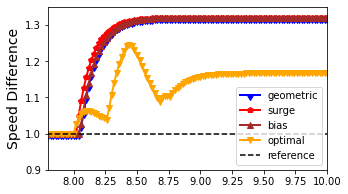

In [5]:
# Compute optimal hidden attack against long memory CUSUM detector
# Input: a sys, in [vt(), dc(), ap(), qd(), RLC(), DCS(), dcspeed()]
sys = 'vt'

optimal_attack = short_mem_opt_attack(eval(f'{sys}()'), short_window = 25, which_optimal_row = 20, verbose = 1)
updated_system = get_attacked_state(eval(f'{sys}()'), optimal_attack)

fig, ax = plt.subplots(figsize=(5, 3))
ax.set_ylim(0.9,1.35)
ax.set_xlim(7.8,10)
ax.plot(updated_system.t_arr, attacked_state(eval(f'{sys}()'), 'geo'), label='geometric', color = 'blue', linewidth=2, marker=markers.CARETDOWNBASE)
ax.plot(updated_system.t_arr, attacked_state(eval(f'{sys}()'), 'surge'), label='surge', color = 'r', linewidth=2, marker='p')
ax.plot(updated_system.t_arr, attacked_state(eval(f'{sys}()'), 'bias'), label='bias', color = 'brown', linewidth=2, marker='^')

ax.plot(updated_system.t_arr, updated_system.y_real_arr, label='optimal', color = 'Orange', linewidth=2, marker='v')
ax.plot(updated_system.t_arr, updated_system.ref, label='reference', color='black', ls='--')
ax.axhspan(2, 3, color='r', alpha=0.5)
ax.set_ylabel('Speed Difference', fontsize=14)
ax.legend()
fig.show()
